## Calibración de modelos dinámicos

Distintos modelos han propuesto métodos para pronosticar como se relaciona la aparición de defectos en un proceso de V&V con
el tiempo de ejecución del test, éste tipo de modelo es útil para pronosticar el tiempo remanente de test y la magnitud de los
defectos latentes remanentes luego de el.

Por su parte la magnitud de los defectos latentes remanentes está directamente relacionada con el tiempo medio entre fallas (MTTF-Mean time to fail) del software una vez liberado.

Conceptualmente los modelos se basan en que no todas las funciones implementadas son igualmente valiosas para la organización o, lo
que es otra forma de verlo, no todas se ejecutan con la misma frecuencia. Es razonable considerar entonces que aquellos defectos
presentes en funciones muy utilizadas expondrán segmentos de código y los correspondientes defectos que pudieran tener con mas
rapidez que aquellos presentes en segmentos de código menos utilizados.

Este modelo simple no tiene en cuenta que los defectos pueden evidenciarse en presencia de esquemas multicausales, es decir, una combinación de condiciones, aún estando presentes en módulos muy utilizados.

En ambas condiciones es natural asumir que los defectos aparecerán en forma aproximadamente relativa al valor de la función o combinación de condiciones en las que se expresa.

J.D.Musa [^1] propuso una serie de modelos, de creciente grado de dificultad, para pronosticar el tiempo medio entre fallas (MTTF) de un
aplicativo de software sujeto a un proceso de test riguroso y continuo; este tipo de modelos puede ser utilizado para pronosticar
la cantidad de defectos remanentes.

@ARTICLE{5010297,
  author={Iannino, Anthony and Musa, John D. and Okumoto, Kazuhira and Littlewood, Bev},
  journal={IEEE Transactions on Software Engineering}, 
  title={Criteria for Software Reliability Model Comparisons}, 
  year={1984},
  volume={SE-10},
  number={6},
  pages={687-691},
  keywords={Software reliability;Software systems;Engineering management;Reliability engineering;Battery powered vehicles;Software measurement;Software development management;Costs;Predictive models;Model comparisons;predictive validity;software failures;software reliability},
  doi={10.1109/TSE.1984.5010297}}


El mas simple de los modelos propuestos por Musa puede simplificarse en la definición de cual es la tasa de aparición de defectos
($\lambda$) en función del tiempo durante un proceso de test **continuo y exhaustivo**, dicha expresión es


$\lambda(t)=\lambda_0e^{-(\frac{\lambda_0}{\mu_0})\tau}$

Donde $\lambda_0$ es una constante representativa de la **intensidad de defectos al origen** evidenciada al comienzo del proceso de test y $\mu_0$ es la **cantidad de defectos total** presentes al momento del comienzo del test, $\tau$ por su parte el el **tiempo neto** continuo de test sin contar interrupciones.

La tasa de aparición de defectos $\lambda(t)$ puede relacionarse con los defectos detectados en función del tiempo de test mediante


$\mu(\tau)=\int \lambda(\tau) d\tau$

Por lo que

$\mu(\tau)=\mu_0(1-e^{-\frac{\lambda_0}{\mu_0}\tau})$

Las representaciones en el tiempo para un proceso arbitrario de test una vez determinadas las constantes $\mu_0$ y $\lambda_0$ serán 
del tipo

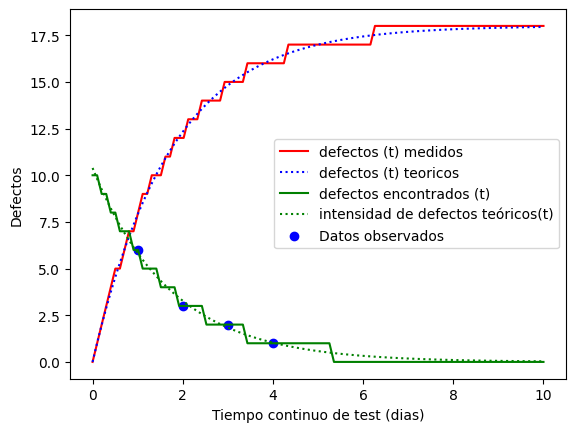

In [1]:
import pandas as pd
import numpy as np
import sys
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.optimize import root_scalar
from scipy.integrate import quad
from scipy.optimize import root_scalar


#*--- Calcula la tasa instantanea de defectos y los defectos acumulados
def mu(t, l0, mu0):
    return np.round(mu0*(1-np.exp(-(l0/mu0)*t)))

def lambda_meassure(t, l0, mu0):
    return np.round(l0*(np.exp(-(l0/mu0)*t)))

def mu_smooth(t, l0, mu0):
    return mu0*(1-np.exp(-(l0*t)/mu0))

def lambda_smooth(t, l0, mu0):
    return l0*(np.exp(-(l0/mu0)*t))

l0=10.39
mu0=18

t_data = np.array([1, 2, 3, 4])        # Tiempo en meses
l_data = np.array([6, 3, 2, 1])  # Esfuerzo instantáneo en persona-mes

t_fit = np.linspace(0, 10, 100)
mu_estimada = mu(t_fit, l0, mu0)
mu_teorica  = mu_smooth(t_fit,l0,mu0)

l_estimada=lambda_meassure(t_fit,l0,mu0)
l_teorica=lambda_smooth(t_fit,l0,mu0)


plt.plot(t_fit, mu_estimada, label='defectos (t) medidos', color='red')
plt.plot(t_fit, mu_teorica, label='defectos (t) teoricos', linestyle=":",color='blue')
plt.plot(t_fit, l_estimada, label='defectos encontrados (t)', color='green')
plt.plot(t_fit, l_teorica, label='intensidad de defectos teóricos(t)',linestyle=":", color='green')


plt.scatter(t_data, l_data, label='Datos observados', color='blue')

plt.xlabel('Tiempo continuo de test (dias)')
plt.ylabel('Defectos')
plt.legend()
plt.show()

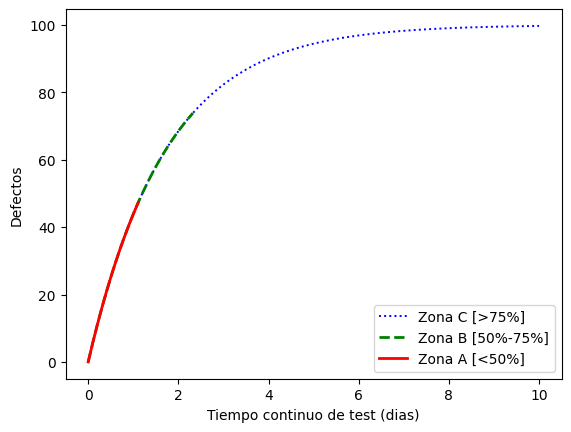

In [2]:
mu_porcentual  = 100*mu_smooth(t_fit,l0,mu0)/mu0

y1 = np.copy(mu_porcentual)
y1[y1 > 50] = np.nan

y2 = np.copy(mu_porcentual)
y2[y2 > 75] = np.nan

plt.plot(t_fit, mu_porcentual, label='Zona C [>75%]', color='blue',linestyle=":",linewidth=1.4)
plt.plot(t_fit, y2, label='Zona B [50%-75%]', linestyle='--',color='green',linewidth=2.0)
plt.plot(t_fit, y1, label='Zona A [<50%]', color='red',linewidth=2.0)

plt.xlabel('Tiempo continuo de test (dias)')
plt.ylabel('Defectos')
plt.legend()
plt.show()


La disponibilidad de las funciones $\lambda(\tau)$ y/o $\mu(\tau)$ es una potente herramienta de gestión pues permite
pronosticar cuanto debe extenderse el proceso de testing para alcanzar un nivel objetivo de defectos residuales al momento
de la liberación del software, los defectos residuales $\mu_r$ vendrán definidos como

$\mu_r=\mu_0-\mu(\tau_r)$

Por lo que es posible mediante las relaciones anteriores despejar el tiempo total de test $\tau_r$ necesario para alcanzarlo.

Este enfoque, útil aún en condiciones aproximadas, presenta la dificultad que normalmente se desconocen los valores de 
$\mu_0$ y $\lambda_0$ al comienzo del test.

## Soluciones empíricas

Las funciones $\lambda(\tau)$ y/o $\mu(\tau)$ dependen únicamente de los valores $\mu_0$ y $\lambda_0$ para definir el valor
de defectos totales encontrados en un momento arbitrario del tiempo de test continuo $\tau$.

Por esa razón para una dada combinación de $\mu_0$ y $\lambda_0$ el perfil de la curva resultante es única, lo que permite que
obteniendo estimadores razonables para ambas constantes poder pronosticar el comportamiento de un esfuerzo de test.

### Linea de base organizacional

Si la organización colecta métricas históricas y dispone de una **linea de base** organizacional para su gestión cuantitativa podrá
estimar el número de defectos con que finaliza la etapa de desarrollo y comienza la etapa de test, el cual es justamente el valor de
$\mu_0$.

Esto puede calcularse a partir de una medición del tamaño del proyecto ($S$) y la **densidad de defectos** ($\delta$) que obtuvo en 
proyectos pasados sobre tecnologías, dominio aplicativo y plataformas similares.

Pudiendo entonces obtener

$\mu_0=\frac{S}{\delta}$

Si bien diferentes proyectos pueden tener tamaños diferentes la relación $\frac{\lambda_0}{\mu_0}$, la cual expresa una velocidad inicial en la detección de defectos, probablemente será (aproximadamente) constante para proyectos similares del pasado. Disponiendo un valor
histórico para ésta relación se puede despejar $\lambda_0$.





### Regresión lineal

Si la organización no dispone de métricas históricas que le permitan estimar los valores de $\mu_0$ y $\lambda_0$ puede lograr una
aproximación a los mismos utilizando los primeros puntos de datos emergiendo del proceso de test para, mediante regresión lineal,
estimar éstos valores.

$\lambda(t)=\lambda_0e^{-(\frac{\lambda_0}{\mu_0})\tau}$

Aplicando logaritmos en ambos términos

$\ln(\lambda(\tau))=\ln(\lambda_0)-\frac{\lambda_0}{\mu_0}\ln(\tau)$

por medio de substitución se puede llevar la forma

$Y(\tau)=\alpha-\beta X(\tau)$

Con

$\alpha=\ln(\lambda_0)$ 

y

$\beta =-\frac{\lambda_0}{\mu_0}$


Suponiendo que se dispone de información de test que indica la siguiente tasa de aparición de defectos
en el tiempo

| t (days)   |      defects      |
|----------|:-------------:|
| 1 |  6 |
| 2 |  3 |
| 3 |  2 |
| 4 |  1 |



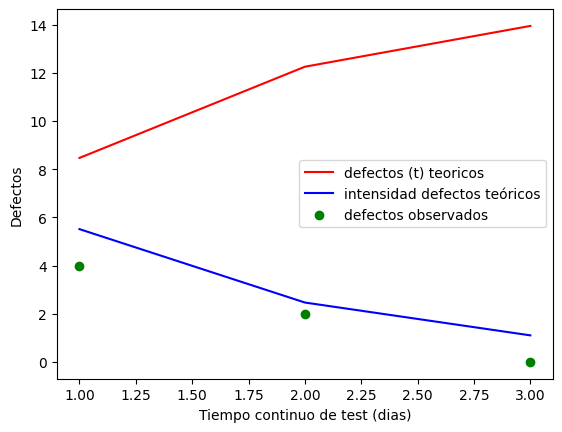

In [14]:
import numpy as np
import matplotlib.pyplot as plt

#*----- Test Dataset

t_test = [1,2,3]
d_test = [4,2,0] 

#*----- Regresión lineal

d_log = np.log(np.array(d_test) + 1)
m,b = np.polyfit(t_test, d_log, 1)

#*----- Calcula coeficientes de regresión
lambda0=np.exp(b)
mu0=-lambda0/m
t=np.array(t_test)

l0=lambda0
m0=mu0

mu_teorica  = mu_smooth(t,lambda0,mu0)
lambda_teorica=lambda_smooth(t,lambda0,mu0)

plt.plot(t, mu_teorica, label='defectos (t) teoricos',color='red')

plt.plot(t, lambda_teorica, label='intensidad defectos teóricos',color='blue')
plt.scatter(t_test, d_test, label='defectos observados', color='green')

plt.xlabel('Tiempo continuo de test (dias)')
plt.ylabel('Defectos')
plt.legend()
plt.show()


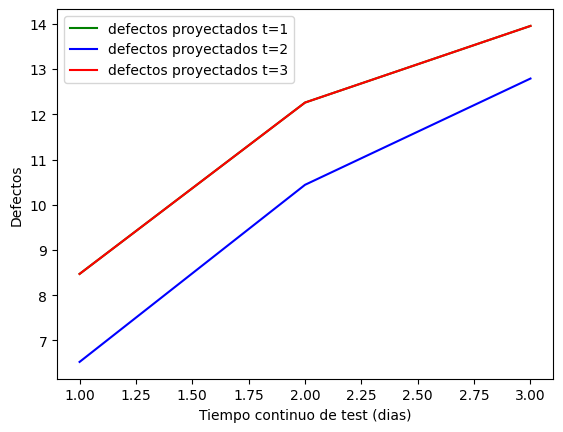

In [15]:
#*----- Test Dataset

t_test = [1,2,3]
d_test = [4,2,0] 

#*----- Regresión lineal

d_log = np.log(np.array(d_test) + 1)
m,b = np.polyfit(t_test, d_log, 1)

#*----- Calcula coeficientes de regresión

lambda0=np.exp(b)
mu0=-lambda0/m

l1=lambda0
m1=mu0

#*----- Test Dataset

t_test = [1,2]
d_test = [4,2] 

#*----- Regresión lineal

d_log = np.log(np.array(d_test) + 1)
m,b = np.polyfit(t_test, d_log, 1)

#*----- Calcula coeficientes de regresión

lambda0=np.exp(b)
mu0=-lambda0/m

l2=lambda0
m2=mu0


mu_teorica1  = mu_smooth(t,l1,m1)
mu_teorica2  = mu_smooth(t,l2,m2)
mu_teorica3  = mu_smooth(t,l0,m1)

plt.plot(t, mu_teorica1, label='defectos proyectados t=1',color='green')
plt.plot(t, mu_teorica2, label='defectos proyectados t=2',color='blue')
plt.plot(t, mu_teorica3, label='defectos proyectados t=3',color='red')

plt.xlabel('Tiempo continuo de test (dias)')
plt.ylabel('Defectos')
plt.legend()
plt.show()



Las estimaciones de parámetros pueden refinarse en la medida que se obtienen mas datos de test